In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ofdm import *
from mod import *
from fading import *
from gauss import *
from estimate import *
from equalize import *
from simulate import *
import random
from simulate_10000 import *

# 1 Mô Phỏng

In [2]:
x_time = 14 # 0-13
y_freq = 3276 # 0-3275
snr = 20
mod_type ="QPSK"


if mod_type == "QPSK":
    z_mod = 2
elif mod_type == "16QAM":
    z_mod = 4
elif mod_type == "64QAM":
    z_mod = 6
else:
    print("Modulation type not supported")
    exit(1)

# đọc dữ liệu từ file Excel
df = pd.read_excel('data/l1_mini_project_ce_eq_dmrs_data.xlsx', sheet_name='Sheet1', header=None)
arr_r = df[0].apply(lambda x: complex(str(x).replace('i', 'j').replace(' ', ''))).to_numpy()

Tạo chuỗi bit ngẫu nhiêu (giá trị 0 và 1) có kích thước 3276 × 13 × (z)

In [3]:
bits = ''.join(str(random.randint(0, 1)) for _ in range((x_time-1)*y_freq*z_mod))


Điều chế  -> 3276x13 ký hiệu

In [4]:
#symbols_16qam  = bits_to_symbols_16QAM(bits)
symbol_mod = modulation(bits, mod_type)
print(f"Length of symbol_mod: {len(symbol_mod)}")

Length of symbol_mod: 42588


Ánh xạ vào lưới tài nguyên :trên xuống dưới, trừ trái sang phải:

In [5]:
grid = np.zeros((y_freq, x_time), dtype=complex)

for i in range(y_freq):
    for j in range(x_time):
        if j < 3:
            grid[i, j] = symbol_mod[j*y_freq + i]
        elif j==3:
            grid[i, j] = arr_r[i]
        else:
            grid[i, j] = symbol_mod[(j-1)*y_freq + i]

Precoding (chưa xong)

In [6]:
# precoded in SC-FDMA
# giữ nguyên pilot chỉ DFT các giá trị còn lại

Từ grid -> ánh xạ sang OFDM

In [7]:
# ofdm cần thêm CP -> tín hiệu miền thời gian 61440 mẫu -> mà mới có 3276 * 14 = 61376 -> padding thêm

ofdm = np.zeros((4384, x_time), dtype=complex)
for i in range(x_time):
    ofdm[:, i] = ofdm_single_symbol(grid[:, i], 4096, 288)
    
# Ghép tất cả OFDM symbol thành 1 chuỗi dài 61376 mẫu
ofdm_signal = ofdm.flatten(order='F')  # flatten theo cột (trước sau)
# Padding thêm 64 mẫu 0 để đủ 61440 mẫu
padding = np.zeros(64, dtype=complex)
ofdm_signal = np.concatenate((ofdm_signal, padding))


Cho tín hiệu OFDM qua Fading channel  TDLB100-25

TDL: Tapped Delay Line – mô hình kênh đa đường có nhiều taps
B: Profile B (mức phản xạ trung bình)
100ns: Delay spread
25Hz: Doppler shift (UE di chuyển, tốc độ ~3km/h)

In [8]:
fs = 122.88e6  # sampling rate (Hz) cho 5G LTE BW = 20MHz (chuẩn)
#channel_h = generate_tdlb_channel(fs)
#faded_signal = apply_fading_channel(ofdm_signal, channel_h)

channel_response = generate_rayleigh_channel(fs)
faded_signal = apply_rayleigh_channel(ofdm_signal, channel_response)

#faded_signal = ofdm_signal

Tiếp tục cho tín hiệu đi qua nhiễu Gauss có SNR 20dB


In [9]:
rx_signal = add_awgn(faded_signal, snr_db=snr)
#rx_signal = faded_signal

Giải điều chế OFDM

In [10]:
#rx_grid = ofdm_demodulate(rx_signal, fft_size=4096, cp_len=288, num_symbols=14)
rx_grid = ofdm_demodulate(rx_signal, fft_size=4096, cp_len=288, num_symbols=14)

# Cắt lại phần tương ứng với 3276 subcarriers (đầu tiên)
rx_grid = rx_grid[:3276, :]  # Kích thước (3276 x 14)

De-precoding (chưa xong)

In [11]:
# dùng idft để giải precoding trừ cột pilot

Giải điều chế 16QAM hardbit

In [12]:
data_cols = [i for i in range(14) if i != 3]  # loại bỏ cột 3 (DMRS)
rx_bits_all = []

for col in data_cols:
    rx_symbols = rx_grid[:, col]
    bits_col = demodulation(rx_symbols, mod_type)
    rx_bits_all.extend(bits_col)

print("Tổng số bit sau giải điều chế:", len(rx_bits_all))  # sẽ là 3276 * 13 * 4 = 170352


Tổng số bit sau giải điều chế: 85176


So sánh sai lệch dữ dữ liệu 16QAM giữa TX & RX theo MSE

In [13]:

bits_rx = np.array([int(b) for b in bits], dtype=int)
bits_tx = np.array([int(b) for b in rx_bits_all], dtype=int)

#mse_bits = np.mean((bits_rx - bits_tx) ** 2)
mse_symbol_full = np.mean(np.abs(rx_grid - grid) ** 2)
print("MSE giữa bit TX và RX:", mse_symbol_full)

MSE giữa bit TX và RX: 3.962189701885455


So sánh và tính toán sai lệch bit (BER) giữa đầu phát và đầu thu.

In [14]:
ber = np.mean(bits_tx != bits_rx)
print("BER:", ber)

BER: 1.0


# 2 ƯỚC LƯỢNG

Uớc lượng kênh truyền bằng thuật toán LS. 


In [15]:
#https://tailieusinhvien.net/phan-tich-so-sanh-ky-thuat-uoc-luong-kenh-ls-va-mmse-trong-he-thong-ofdm-duoi-nuoc-7436/
df = pd.read_excel('data/l1_mini_project_ce_eq_dmrs_data.xlsx', sheet_name='Sheet1', header=None)
X = df[0].apply(lambda x: complex(str(x).replace('i', 'j').replace(' ', ''))).to_numpy()

Y = rx_grid[:, 3]  # cột DMRS

# X= H.x +n -> tìm H sao cho ||Y-Hx||^2 min; H = X^-1 .Y
h_ls = estimate_channel_ls(X, Y)

Cân bằng kênh truyền bằng thuật toán ZF. 


In [16]:
rx_grid_equalized = equalize_zf(rx_grid, h_ls)
# Giải điều chế 16-QAM và tính BER/MSE
rx_bits_all_zf = []
data_cols = [i for i in range(14) if i != 3]
for col in data_cols:
    rx_symbols = rx_grid_equalized[:, col]
    bits_col = demodulation(rx_symbols, mod_type)
    rx_bits_all_zf.extend(bits_col)

bits_tx = np.array([int(b) for b in bits], dtype=int)
bits_rx_zf = np.array([int(b) for b in rx_bits_all_zf], dtype=int)
mse_zf = np.mean(np.abs(rx_grid_equalized - grid) ** 2)
ber_zf = np.mean(bits_tx != bits_rx_zf)

print(f"MSE (ZF): {mse_zf:.6f}")
print(f"BER (ZF): {ber_zf:.6f}")

MSE (ZF): 0.011029
BER (ZF): 0.000000


Thay đổi giá trị SNR từ 0 đến 30, khoảng cách 2dB. Vẽ biểu đồ MSE và biểu đồ BER.


SNR = 0 dB → BER = 0.18201, MSE = 2.11018
SNR = 2 dB → BER = 0.11648, MSE = 1.23595
SNR = 4 dB → BER = 0.06293, MSE = 0.63230
SNR = 6 dB → BER = 0.02565, MSE = 0.32085
SNR = 8 dB → BER = 0.00735, MSE = 0.18102
SNR = 10 dB → BER = 0.00113, MSE = 0.11431
SNR = 12 dB → BER = 0.00007, MSE = 0.07183
SNR = 14 dB → BER = 0.00000, MSE = 0.04531
SNR = 16 dB → BER = 0.00000, MSE = 0.02777
SNR = 18 dB → BER = 0.00000, MSE = 0.01744
SNR = 20 dB → BER = 0.00000, MSE = 0.01110
SNR = 22 dB → BER = 0.00000, MSE = 0.00702
SNR = 24 dB → BER = 0.00000, MSE = 0.00443
SNR = 26 dB → BER = 0.00000, MSE = 0.00277
SNR = 28 dB → BER = 0.00000, MSE = 0.00173
SNR = 30 dB → BER = 0.00000, MSE = 0.00110


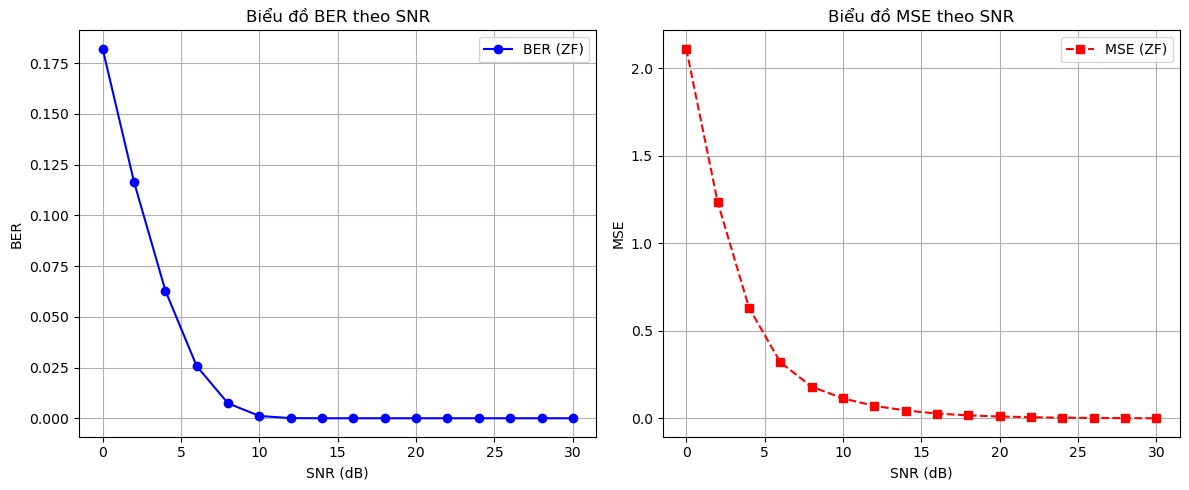

In [17]:
equalizer_mode ="ZF"
snr_range_db, ber_results, mse_results = simulate(faded_signal, X, bits, grid, equalizer_mode, mod_type)
    
    
plt.figure(figsize=(12, 5))
# BER
plt.subplot(1, 2, 1)
plt.plot(snr_range_db, ber_results, 'bo-', label=f'BER ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Biểu đồ BER theo SNR')
plt.grid(True)
plt.legend()

# MSE
plt.subplot(1, 2, 2)
plt.plot(snr_range_db, mse_results, 'rs--', label=f'MSE ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('Biểu đồ MSE theo SNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



So sánh MSE và BLER giữa có và không có sử dụng ước lượng/cân bằng kênh truyền. 


# 3 Phát triển và đánh giá thuật toán ước lượng kênh truyền nâng cao.

Thay thế thuật toán LS bằng thuật toán ước lượng kênh truyền nâng cao MMSE, sử 
dụng bộ cân bằng MMSE và 

In [18]:

h_mmse = estimate_channel_mmse(X, Y, snr_db=snr)  # SNR = 20 dB

# Áp dụng cân bằng MMSE thay vì ZF
snr_db = snr  # Giả định SNR = 20 dB như trong notebook
rx_grid_equalized_mmse = np.zeros_like(rx_grid, dtype=complex)
rx_grid_equalized_mmse = equalize_mmse(rx_grid, h_mmse, snr_db)
#rx_grid_equalized_mmse = equalize_zf(rx_grid, h_mmse)
# Giải điều chế 16-QAM và tính BER/MSE
rx_bits_all_mmse = []
data_cols = [i for i in range(14) if i != 3]
for col in data_cols:
    rx_symbols = rx_grid_equalized_mmse[:, col]
    bits_col = demodulation(rx_symbols, mod_type)
    rx_bits_all_mmse.extend(bits_col)

bits_tx = np.array([int(b) for b in bits], dtype=int)
bits_rx_mmse = np.array([int(b) for b in rx_bits_all_mmse], dtype=int)
mse_mmse = mse_zf = np.mean(np.abs(rx_grid_equalized_mmse - grid) ** 2)
ber_mmse = np.mean(bits_tx != bits_rx_mmse)

print(f"MSE (MMSE): {mse_mmse:.6f}") # tính theo ký hiệu phức
print(f"BER (MMSE): {ber_mmse:.6f}") # tính theo bit


MSE (MMSE): 0.010731
BER (MMSE): 0.000000


so sánh biểu đồ MSE, BER với thuật toán LS/ZF.

SNR = 0 dB → BER = 0.14808, MSE = 0.47688
SNR = 2 dB → BER = 0.09337, MSE = 0.35864
SNR = 4 dB → BER = 0.04964, MSE = 0.26397
SNR = 6 dB → BER = 0.01913, MSE = 0.18786
SNR = 8 dB → BER = 0.00511, MSE = 0.13255
SNR = 10 dB → BER = 0.00069, MSE = 0.09087
SNR = 12 dB → BER = 0.00001, MSE = 0.06002
SNR = 14 dB → BER = 0.00000, MSE = 0.04057
SNR = 16 dB → BER = 0.00000, MSE = 0.02608
SNR = 18 dB → BER = 0.00000, MSE = 0.01687
SNR = 20 dB → BER = 0.00000, MSE = 0.01072
SNR = 22 dB → BER = 0.00000, MSE = 0.00674
SNR = 24 dB → BER = 0.00000, MSE = 0.00432
SNR = 26 dB → BER = 0.00000, MSE = 0.00277
SNR = 28 dB → BER = 0.00000, MSE = 0.00175
SNR = 30 dB → BER = 0.00000, MSE = 0.00109


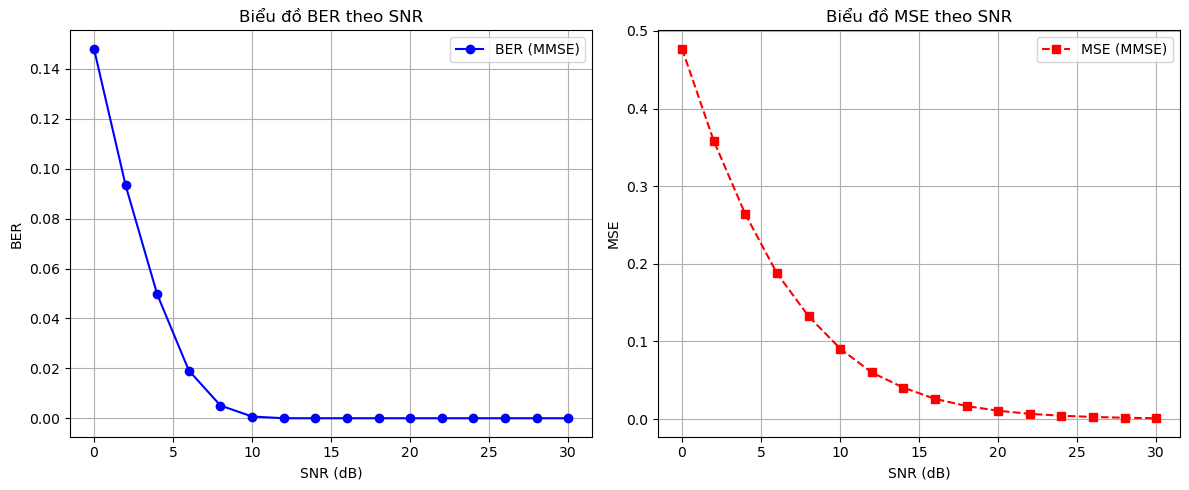

In [19]:
equalizer_mode = 'MMSE'
snr_range_db, ber_results_mmse, mse_results_mmse = simulate(faded_signal, X, bits, grid, equalizer_mode, mod_type)

plt.figure(figsize=(12, 5))
# BER
plt.subplot(1, 2, 1)
plt.plot(snr_range_db, ber_results_mmse, 'bo-', label=f'BER ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Biểu đồ BER theo SNR')
plt.grid(True)
plt.legend()

# MSE
plt.subplot(1, 2, 2)
plt.plot(snr_range_db, mse_results_mmse, 'rs--', label=f'MSE ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('Biểu đồ MSE theo SNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



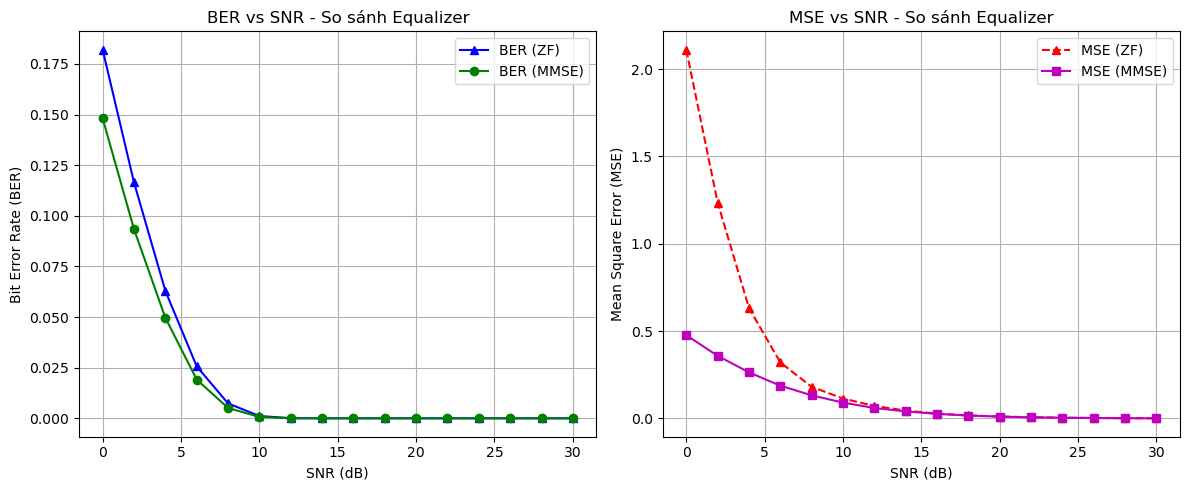

In [20]:
# KẾT HỢP 2 ĐỒ THỊ
plt.figure(figsize=(12, 5))

# === Biểu đồ BER ===
plt.subplot(1, 2, 1)
plt.plot(snr_range_db, ber_results, 'b^-', label='BER (ZF)')
plt.plot(snr_range_db, ber_results_mmse, 'go-', label='BER (MMSE)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR - So sánh Equalizer')
plt.grid(True)
plt.legend()

# === Biểu đồ MSE ===
plt.subplot(1, 2, 2)
plt.plot(snr_range_db, mse_results, 'r^--', label='MSE (ZF)')
plt.plot(snr_range_db, mse_results_mmse, 'ms-', label='MSE (MMSE)')
plt.xlabel('SNR (dB)')
plt.ylabel('Mean Square Error (MSE)')
plt.title('MSE vs SNR - So sánh Equalizer')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Thực hiện đánh giá lại các phương pháp với số lượng mẫu là 10000 lưới tài nguyên, 
bổ sung thêm các kiểu điều chế QPSK và 64QAM.

Loop 1/4 | SNR = 0 dB → BER = 0.34446, MSE = 0.62775
Loop 1/4 | SNR = 2 dB → BER = 0.30838, MSE = 0.55026
Loop 1/4 | SNR = 4 dB → BER = 0.27003, MSE = 0.47126
Loop 1/4 | SNR = 6 dB → BER = 0.23232, MSE = 0.39736
Loop 1/4 | SNR = 8 dB → BER = 0.19641, MSE = 0.33093
Loop 1/4 | SNR = 10 dB → BER = 0.15981, MSE = 0.26837
Loop 1/4 | SNR = 12 dB → BER = 0.12910, MSE = 0.21545
Loop 1/4 | SNR = 14 dB → BER = 0.09996, MSE = 0.16879
Loop 1/4 | SNR = 16 dB → BER = 0.07582, MSE = 0.12812
Loop 1/4 | SNR = 18 dB → BER = 0.05633, MSE = 0.09790
Loop 1/4 | SNR = 20 dB → BER = 0.04031, MSE = 0.07189
Loop 1/4 | SNR = 22 dB → BER = 0.02902, MSE = 0.05266
Loop 1/4 | SNR = 24 dB → BER = 0.01995, MSE = 0.03760
Loop 1/4 | SNR = 26 dB → BER = 0.01317, MSE = 0.02760
Loop 1/4 | SNR = 28 dB → BER = 0.00905, MSE = 0.01936
Loop 1/4 | SNR = 30 dB → BER = 0.00602, MSE = 0.01373
Loop 2/4 | SNR = 0 dB → BER = 0.32751, MSE = 0.57078
Loop 2/4 | SNR = 2 dB → BER = 0.28381, MSE = 0.47219
Loop 2/4 | SNR = 4 dB → BER = 0.239

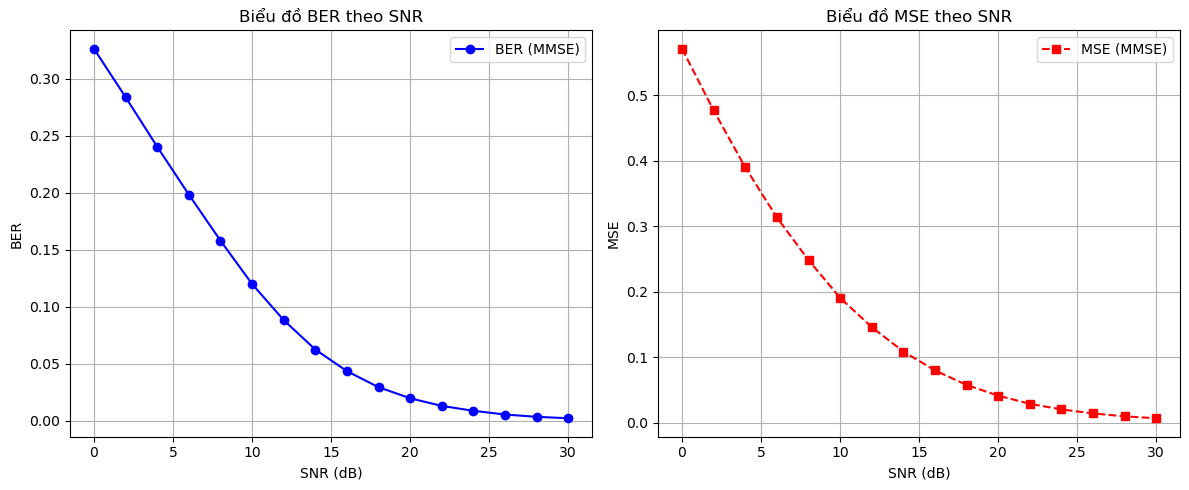

ber_results_mmse_10k: [0.32630523856485394, 0.2838989269277731, 0.24040075842960457, 0.19847580304311074, 0.15809911242603553, 0.120069033530572, 0.08843013290128675, 0.06259392317084625, 0.04362437775899315, 0.02957112332112332, 0.01985741288625904, 0.013143373720296798, 0.008849323753169908, 0.005597233962618578, 0.003561742744435052, 0.0023201958298112147]
mse_results_mmse_10k: [0.5710262661645402, 0.47677272552816125, 0.3898250774692369, 0.3133201376131628, 0.2481717140674149, 0.19054582414227816, 0.14576376852348832, 0.10853304992045762, 0.079685623771668, 0.05742820407460553, 0.041128946630703773, 0.028629127306012695, 0.020137564838756318, 0.013920952279653384, 0.009444475285232902, 0.006595130145995132]
avg ber at 20dB: 0.01985741288625904
avg mse at 20dB: 0.041128946630703773


In [21]:
equalizer_mode = 'MMSE'
mod_type = '16QAM'  # Hoặc QPSK, 16QAM
snr_range_db_10k, ber_results_mmse_10k, mse_results_mmse_10k = simulate_10000(4, equalizer_mode,mod_type, X )

plt.figure(figsize=(12, 5))
# BER
plt.subplot(1, 2, 1)
plt.plot(snr_range_db_10k, ber_results_mmse_10k, 'bo-', label=f'BER ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Biểu đồ BER theo SNR')
plt.grid(True)
plt.legend()

# MSE
plt.subplot(1, 2, 2)
plt.plot(snr_range_db_10k, mse_results_mmse_10k, 'rs--', label=f'MSE ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('Biểu đồ MSE theo SNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("ber_results_mmse_10k:", ber_results_mmse_10k)
print("mse_results_mmse_10k:", mse_results_mmse_10k)

print("avg ber at 20dB:", ber_results_mmse_10k[10])  # 20dB là chỉ số thứ 10 trong mảng
print("avg mse at 20dB:", mse_results_mmse_10k[10])